# Classifying the Higgs Boson with Neural Networks
### Or Randomly Searching Parameters of a Neural Network 

Michael Murrietta

4/19/2018

## Introduction
As the title suggests this assignment attempts to build a neural network that will classify the Higgs Boson and turns into a somewhat random search of the parameter space related to these models. The data is provided by the UC Irvine Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/HIGGS) and consists of solely numeric data generated using Monte Carlo simulations [1]. The data set is massive at 11,000,000 rows and 29 variables. The first variable is the target and the remaining 28 are either kinematic properites measured by the particle detector (the first 21) or are some derivative of those variables (the last 7).

A paper [2] was written purporting a 0.88 area under the receiver-operating-characteristic curve (AUROC) but knowledge of the model used was not gathered prior to this assignment but some information about it was included in a final training alongside the best model derived from manual exploration.

## Abstract
The first 1,000,000 rows of data were imported as a training/validation set and, just as mentioned in the data set description, the last 500,000 rows were imported as a test set. A 5-hour search of random 3-hidden layer models was performed but yielded little insight. A more intentional exploration followed and explored optimizers, number of layers, activation functions, number of nodes, and other parameters. The best models from each step formed the base model for the next parameter space to explore. The final result was a model with an AUROC above 0.84.

## Methods
The exploration was purposeful and repetitive so a helper function and eventually a helper class were created. The function was helpful in early stages when number of epochs was set to 5 or 10 but an inspection of the training epoch metrics suggested longer training could produce better models. The helper/convenience class allows for access to all information related to the models and thus provides convenience when building and testing multiple models and also allows for plotting training/validation loss.

Since the paper mentioned in class achieved an AUROC of 0.88 the main measure of effectiveness chosen in this study was also AUROC. The main methods of exploration were to pick a parameter and then build a few models using different values for that parameter. Only in the early stages were multiple parameters explored simultaneously, in later models this single parameter approach was taken. There are certainly downfalls to this approach and they are discussed further in the conclusion section. To combat one likely problem with this approach occasionally a poor performing configuration was used in a later stage of parameter exploration.

In order to determine if training was completed the change in loss and accuracy was assessed over the training and validation data using basic line plots with the metric on the y-axis and the epoch on the x-axis. The final exploration focused on the completion of training and utilized a callback function in `keras` that was also mentioned in the paper by Baldi, Sadowski, and Whiteson that allowed for early stopping. Obviously this is extremely useful for training with a large number of epochs and essentially indicates when training is over however this is dependent on the settings of the parameters of this function (like `patience` which asks how many epochs of sub-par between-epoch differences can be tolerated).

Most of the code in this notebook was previously run in the `IPython` console to reduce overhead and generally performed between 6 to 10 seconds faster per epoch than when run in the Jupyter Notebook.

### A Note Before Running All Code
Most of the code here is exploratory and mostly self contained. The only cells that need to be run have a first-line-comment of `RUN THIS CELL`. Any other cell can be run individually. One exception is the 4 cells in the Optimizer Tuning section, these need to be run in order if attempting to run any of them; skipping the Optimizer Tuning section is fine and the next cell after those 4 is self contained and uses the results of all sections before it.

In [6]:
#RUN THIS CELL

import keras
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adagrad, Adam, Adamax, Nadam, RMSprop, Adadelta
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
#thank you Professor, I probably could have used this early stopping callback a long time ago!
from keras.callbacks import EarlyStopping

In [3]:
#RUN THIS CELL

#documentation says the last 500000 are used as the test set. the data has 11000000 rows total, using the first
#1 million rows for the training/validation data
data=pd.read_csv("~/Downloads/HIGGS.csv",nrows=1000000,header=None)
test_data=pd.read_csv("~/Downloads/HIGGS.csv",nrows=500000,header=None,skiprows=11000000 - 500000)

y=np.array(data.loc[:,0])
x=np.array(data.loc[:,1:])
x_test=test_data.loc[:,1:]
y_test=test_data.loc[:,0]

In [3]:
#RUN THIS CELL

#This is a function I used to help maintain sanity as I explored different model configurations. The first one 
#was used only once and just allowed me to specify however many layers I wanted and the learning rate and decay 
#rate for the `SGD` optimizer. As will be mentioned below, this really just allowed for exploration of the 
#learning and decay rates. The second function allows for different optimizers to be used but only allows use of 
#the default parameters for those optimizers (I tried to get the `**kwargs` working but I did not work it out as
#quickly as I thought I would).

def model_test(layers, opt, opt_args=None, mtrcs=['accuracy', 'mae'], epochs= 5, verbose=True):
	#layers is a list of lists where each inner list defines a dens layer
	#	for layer in layers: layer[0] is # of nodes in layer, layer[1] is
	#	kernel initializer, layer[2] is activation function
	model = Sequential()
	layer = layers[0]
	model.add(Dense(layer[0], input_dim=x.shape[1], kernel_initializer=layer[1], activation=layer[2]))
	for layer in layers[1:]:
		model.add(Dense(layer[0], kernel_initializer=layer[1], activation=layer[2]))
	model.add(Dense(1, kernel_initializer=layers[0][1], activation='sigmoid')) #uses 1st layer's initializer

	#for now just have opt be default
	model.compile(loss='binary_crossentropy', metrics=mtrcs, optimizer=opt)

	batch_size=100
	model.fit(x, y, epochs=epochs, batch_size=batch_size, verbose=2)
	score = model.evaluate(x_test, y_test, batch_size=batch_size)
	#compute and print results
	s = score + [roc_auc_score(y_test,model.predict(x_test))]
	if verbose:
		scoreStr = ["{:>20}: {:>.4}".format("Test Loss",score[0])] + \
			["{:>20}: {:>.4}".format("Test {}".format(x), y) for x, y in zip(mtrcs, score[1:])] + \
			["{:>20}: {:>.4}".format("Test ROCAUC", s[-1])]
		print("\n".join(scoreStr))
	#return results
	return s

Below is a cell that will take around 5 hours to compute as it runs 180 different configurations of a 2-hidden layer neural network. This was a lazy attempt to get some insight and in the end I only really learned about the SGD optimizer! Particularly that with these networks I should keep the learning rate at either 0.01 or 0.03 and the decay rate between 0 and 0.00018, all models that did not have these properties were terrible and sometimes worse than a guess where the receiver-operating characteristic area-under-the-curve (ROCAUC) was less than 0.5.

In [ ]:
##Dont run unless you want to wait about 5 hours...
# import random
# import itertools
# layer_list = [[[x*10, "uniform", random.choice(['relu','tanh','sigmoid'])] for x in np.random.randint(4, 10, 3)]]
# lrates = [0.01*(3**x) for x in range(6)]
# drates = [10*x*(1e-6) for x in range(20)]
# opt_args = itertools.product(lrates, drates)
# params = [x for x in itertools.product(layer_list, opt_args)]

# sdat = []
# for i, param in enumerate(params):
# 	print("Trial {:>3} of {:>3}".format(i, len(params)))
# 	sdat.append(model_test_old(param[0], param[1]))

Previous to the above shotgun approach a more manual exploration was done yielded a few models with AUROC around 0.82. Some things learned from this previous work was that using a batch size of 100 is probably the best for this case since a smaller size greatly increases the time needed to train and a larger number greatly reduces the AUROC. The best of these became the starting point for the more intentional exploration that follows. The following cells explore the following aspects of a neural network in the following order:
+ <b>Optimizers</b>: Explored all optimizers in Keras and found `Adadelta` to be best in this case
+ <b>Number of Layers</b>: Used between 2 and 5 hidden layers, found 3 hidden layers to be best
+ <b>Activations</b>: Previous exploration used only the `relu` activation on every layer, here the `tanh` activation was tried at various layers. It was found that using the `tanh` activation in the first layer was best.
+ <b>Number of Nodes</b>: Explored where a good place for a 50 node layer amongst the 80 node layers would be. The results showed that having the first layer use 50 nodes and the others use 80 nodes was the best of those tried.
+ <b>Kernel Initializers</b>: There are nearly a dozen kernel initializers included in Keras and about 5 of them were tried. The results showed that the `Orthogonal` initializer worked best with the model that was in use at this point.
+ <b>Number of Nodes 2</b>: Explored the number of nodes again but this time trying different values than just 50 and 80. Of the configurations tried the best was 20, 100, 100, and 140 nodes, respectively.
+ <b>Activations 2</b>: Previously only explored `relu` and `tanh`, now included a layer with no activation function which makes the layer just perform a linear transformation on the output of the previous layer. The best result in this section used a linear-transformation-only layer at the input layer. Intuitively this can be perceived as the model allowing the input signals to move through at least one layer before dropping their effect. Also at this point the number of epochs was increased to 15.

#### Searching for a New Optimizer
All `keras` optimizers were imported and trialed here. Most of them are adaptive and mention that it is best to leave their parameters at their default values so that is exactly what was done. The `Adadelta` optimizer was the best at this point and continued on.

In [4]:
#--------------------------------------------------------------------------
#lets try some of the better models from manual exploration
#this layer setup comes from one that had a rocauc of 0.8276
#try a few different optimizers
opts = [Adagrad(), Adam(), Adamax(), Nadam(), RMSprop(), Adadelta()]
names = "Adagrad, Adam, Adamax, Nadam, RMSprop, Adadelta".split(', ')
layer_list = [[[x, "uniform", "relu"] for x in [50, 80, 80]]]
for i, opt in enumerate(opts):
	print("-*"*40)
	print("OPTIMIZER: {}".format(names[i]))
	np.random.seed(128)
	model_test(layer_list[0], opt, epochs=10)

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
OPTIMIZER: Adagrad
Epoch 1/10
 - 25s - loss: 0.6078 - acc: 0.6653 - mean_absolute_error: 0.4224
Epoch 2/10
 - 22s - loss: 0.5833 - acc: 0.6887 - mean_absolute_error: 0.4008
Epoch 3/10
 - 22s - loss: 0.5757 - acc: 0.6951 - mean_absolute_error: 0.3945
Epoch 4/10
 - 22s - loss: 0.5702 - acc: 0.6999 - mean_absolute_error: 0.3901
Epoch 5/10
 - 22s - loss: 0.5656 - acc: 0.7035 - mean_absolute_error: 0.3862
Epoch 6/10
 - 22s - loss: 0.5619 - acc: 0.7070 - mean_absolute_error: 0.3831
Epoch 7/10
 - 22s - loss: 0.5591 - acc: 0.7093 - mean_absolute_error: 0.3808
Epoch 8/10
 - 22s - loss: 0.5568 - acc: 0.7112 - mean_absolute_error: 0.3788
Epoch 9/10
 - 22s - loss: 0.5549 - acc: 0.7131 - mean_absolute_error: 0.3772
Epoch 10/10
 - 21s - loss: 0.5533 - acc: 0.7142 - mean_absolute_error: 0.3758
500000/500000 [==============================] - 9s 18us/step
           Test Loss: 0.5518
       Test accuracy: 0.7151
         

#### Number of Layers
A few different network setups were tested with between 2 and 5 hidden layers. The best used 3 hidden layers. The worst used 5 hidden layers and produced AUROC values near 0.5.

In [ ]:
#exploring number of layers
layer_list = [[[x*10, "uniform", "relu"] for x in [8, 8, 8]],
	[[x*10, "uniform", "relu"] for x in [8, 8, 8, 8]],
	[[x*10, "uniform", "relu"] for x in [8, 8, 8, 8, 8]],
	[[x*10, "uniform", "relu"] for x in [8, 8, 8, 8, 8, 8]]]

sdat = []
opt = Adadelta()
for i, layer in enumerate(layer_list):
	print("-*"*40)
	print("LAYER CONFIG: {}".format(i))
	np.random.seed(128)
	sdat.append(model_test(layer, opt, epochs=10))

#### Exploring Activations: `tanh`
The hyperbolic tangent activation was used as an activation on different layers, it was found the be best used with the input layer.

In [ ]:
#Exploring the use of something other than `relu`, namely, `tanh`
layer_list = [[[80, "uniform", x] for x in ["tanh", "relu", "relu", "relu"]],
	[[80, "uniform", x] for x in ["relu", "tanh", "relu", "relu"]],
	[[80, "uniform", x] for x in ["relu", "relu", "tanh", "relu"]],
	[[80, "uniform", x] for x in ["relu", "relu", "relu", "tanh"]],
	[[80, "uniform", x] for x in ["tanh", "relu", "relu", "tanh"]]]

sdat = []
opt = Adadelta()
for i, layer in enumerate(layer_list):
	print("-*"*40)
	print("LAYER CONFIG: {}".format(i))
	np.random.seed(128)
	sdat.append(model_test(layer, opt, epochs=10))

#### Number of Nodes
This is the first exploration into the number of nodes. Not much information was gained other than it is good to have less nodes in the first layer than in the other layers.

In [ ]:
#testing number of nodes in each layer.
layer_list = [[[i, "uniform", x] for i, x in zip([50, 80, 80, 80], ["tanh", "relu", "relu", "relu"])],
	[[i, "uniform", x] for i, x in zip([80, 50, 80, 80], ["tanh", "relu", "relu", "relu"])],
	[[i, "uniform", x] for i, x in zip([80, 80, 50, 80], ["tanh", "relu", "relu", "relu"])],
	[[i, "uniform", x] for i, x in zip([80, 80, 80, 50], ["tanh", "relu", "relu", "relu"])],
	[[i, "uniform", x] for i, x in zip([50, 80, 80, 50], ["tanh", "relu", "relu", "relu"])]]

sdat = []
opt = Adadelta()
for i, layer in enumerate(layer_list):
	print("-*"*40)
	print("LAYER CONFIG: {}".format(i))
	np.random.seed(128)
	sdat.append(model_test(layer, opt, epochs=10))

#### Kernel Initializers
The `orthogonal` and `he_normal` kernel initializers were the best of the sample that was tested.

In [ ]:
#exploring some of the kernel initializers included in keras
layer_list = [[[i, "VarianceScaling", x] for i, x in zip([50, 80, 80, 80], ["tanh", "relu", "relu", "relu"])], #0.8296
	[[i, "orthogonal", x] for i, x in zip([50, 80, 80, 80], ["tanh", "relu", "relu", "relu"])], #0.8326
	[[i, "lecun_uniform", x] for i, x in zip([50, 80, 80, 80], ["tanh", "relu", "relu", "relu"])], #0.8305
	[[i, "lecun_normal", x] for i, x in zip([50, 80, 80, 80], ["tanh", "relu", "relu", "relu"])], #0.8289
	[[i, "he_normal", x] for i, x in zip([50, 80, 80, 80], ["tanh", "relu", "relu", "relu"])]] #0.8321

sdat = []
opt = Adadelta()
for i, layer in enumerate(layer_list):
	print("-*"*40)
	print("LAYER CONFIG: {}".format(i))
	np.random.seed(128)
	sdat.append(model_test(layer, opt, epochs=10))

#### Exploring the Number of Nodes
The number of nodes in in each layer was varied. It was found that a low number of nodes in the input layer and a progressively increasing number of nodes in the following three layers performed best. Oddly, the number of nodes in the input layer that worked best was less than the number of input variables. This number (20) is very close to the number of distinct (not derived) variables (21).

In [ ]:
#number of nodes revisited. thinking that the best number of nodes used in each layer depends on the layer
#before it and also the layer after it... essentially depends on the number of input features and the 
#number of classes. Here is just a large list of different node configurations for the 3 hidden layer model
#that has been used
layer_list = [[[i, "orthogonal", x] for i, x in zip([40, 80, 80, 80], ["tanh", "relu", "relu", "relu"])],
	[[i, "orthogonal", x] for i, x in zip([30, 80, 80, 80], ["tanh", "relu", "relu", "relu"])],
	[[i, "orthogonal", x] for i, x in zip([20, 80, 80, 80], ["tanh", "relu", "relu", "relu"])],
	[[i, "orthogonal", x] for i, x in zip([10, 80, 80, 80], ["tanh", "relu", "relu", "relu"])],
	[[i, "orthogonal", x] for i, x in zip([20, 50, 80, 80], ["tanh", "relu", "relu", "relu"])], #0.8291
	[[i, "orthogonal", x] for i, x in zip([20, 80, 50, 80], ["tanh", "relu", "relu", "relu"])], #0.8278
	[[i, "orthogonal", x] for i, x in zip([20, 80, 80, 50], ["tanh", "relu", "relu", "relu"])],
	[[i, "orthogonal", x] for i, x in zip([20, 100, 80, 80], ["tanh", "relu", "relu", "relu"])], #0.8314
	[[i, "orthogonal", x] for i, x in zip([20, 80, 100, 80], ["tanh", "relu", "relu", "relu"])], #0.8285
	[[i, "orthogonal", x] for i, x in zip([20, 80, 80, 100], ["tanh", "relu", "relu", "relu"])], #0.8309
	[[i, "orthogonal", x] for i, x in zip([20, 100, 80, 100], ["tanh", "relu", "relu", "relu"])], #0.8309
	[[i, "orthogonal", x] for i, x in zip([20, 100,100,100], ["tanh", "relu", "relu", "relu"])], #0.8334
	[[i, "orthogonal", x] for i, x in zip([20, 100,120,100], ["tanh", "relu", "relu", "relu"])], #0.8327
	[[i, "orthogonal", x] for i, x in zip([20, 100,120,120], ["tanh", "relu", "relu", "relu"])], #0.8315
	[[i, "orthogonal", x] for i, x in zip([20, 100,120,140], ["tanh", "relu", "relu", "relu"])], #0.8326
	[[i, "orthogonal", x] for i, x in zip([20, 100,20,100], ["tanh", "relu", "relu", "relu"])], #0.829
	[[i, "orthogonal", x] for i, x in zip([20, 20,20,20], ["tanh", "relu", "relu", "relu"])], #0.8161
	[[i, "orthogonal", x] for i, x in zip([20, 20,20,100], ["tanh", "relu", "relu", "relu"])], #0.8185
	[[i, "orthogonal", x] for i, x in zip([20, 20,100,100], ["tanh", "relu", "relu", "relu"])], #0.8258
	[[i, "orthogonal", x] for i, x in zip([20, 100,20,20], ["tanh", "relu", "relu", "relu"])], #0.8298
	[[i, "orthogonal", x] for i, x in zip([20, 20,100,20], ["tanh", "relu", "relu", "relu"])], #0.822
	[[i, "orthogonal", x] for i, x in zip([20, 100,100,140], ["tanh", "relu", "relu", "relu"])], #0.8334
	[[i, "orthogonal", x] for i, x in zip([20, 100,100,120], ["tanh", "relu", "relu", "relu"])], #0.8314
	[[i, "orthogonal", x] for i, x in zip([20, 100,100,160], ["tanh", "relu", "relu", "relu"])], #0.8299
	[[i, "orthogonal", x] for i, x in zip([20, 100,100,180], ["tanh", "relu", "relu", "relu"])] #0.8329
	]

sdat = []
opt = Adadelta()
for i, layer in enumerate(layer_list):
	print("-*"*40)
	print("LAYER CONFIG: {}".format(i))
	np.random.seed(128)
	sdat.append(model_test(layer, opt, epochs=10))

#### Incorporating the `None` Activation
Another exploration of the activations was in order. The goal here was first to try the not using an activation function and seeing where it helps the most if at all. Since this new activation literally just performs a linear transformation it was important to also see the effect of using some other activations once again.

In [5]:
#previous exploration of activation functions did not include the absence of a function!
#a linear-transformation only layer is a possibility and so is tried here.
layer_list = [[[i, "orthogonal", x] for i, x in zip([20, 100,100,140], [None, "relu", "relu", "relu"])], #0.836
	[[i, "orthogonal", x] for i, x in zip([20, 100,100,140], ["tanh", None, "relu", "relu"])], #0.8313
	[[i, "orthogonal", x] for i, x in zip([20, 100,100,140], ["tanh", "relu", None, "relu"])], #0.8322
	[[i, "orthogonal", x] for i, x in zip([20, 100,100,140], ["tanh", "relu", "relu", None])], #0.8327
	[[i, "orthogonal", x] for i, x in zip([20, 100,100,140], [None, None, None, None])], #0.6829
	[[i, "orthogonal", x] for i, x in zip([20, 100,100,140], [None, None, None, "relu"])], #0.8188
	[[i, "orthogonal", x] for i, x in zip([20, 100,100,140], [None, "relu", None, "relu"])], #0.8331
	[[i, "orthogonal", x] for i, x in zip([20, 100,100,140], [None, "tanh", None, "relu"])], #0.8306
	[[i, "orthogonal", x] for i, x in zip([20, 100,100,140], ["tanh", None, None, "relu"])], #0.8197
	[[i, "orthogonal", x] for i, x in zip([20, 100,100,140], [None, "tanh", "tanh", "tanh"])], #0.8323
	[[i, "orthogonal", x] for i, x in zip([20, 100,100,140], [None, "tanh", "tanh", "relu"])], #0.8321
	[[i, "orthogonal", x] for i, x in zip([20, 100,100,140], [None, "tanh", "relu", "relu"])] #0.8355
	]

sdat = []
opt = Adadelta()
for i, layer in enumerate(layer_list[0:]):
	print("-*"*40)
	print("LAYER CONFIG: {}".format(i))
	np.random.seed(128)
	sdat.append(model_test(layer, opt, epochs=15))

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
LAYER CONFIG: 0
Epoch 1/15
 - 25s - loss: 0.5874 - acc: 0.6835 - mean_absolute_error: 0.4031
Epoch 2/15
 - 22s - loss: 0.5501 - acc: 0.7163 - mean_absolute_error: 0.3714
Epoch 3/15
 - 21s - loss: 0.5346 - acc: 0.7273 - mean_absolute_error: 0.3590
Epoch 4/15
 - 21s - loss: 0.5227 - acc: 0.7355 - mean_absolute_error: 0.3496
Epoch 5/15
 - 22s - loss: 0.5152 - acc: 0.7410 - mean_absolute_error: 0.3436
Epoch 6/15
 - 21s - loss: 0.5095 - acc: 0.7445 - mean_absolute_error: 0.3392
Epoch 7/15
 - 21s - loss: 0.5059 - acc: 0.7471 - mean_absolute_error: 0.3364
Epoch 8/15
 - 24s - loss: 0.5031 - acc: 0.7488 - mean_absolute_error: 0.3343
Epoch 9/15
 - 21s - loss: 0.5010 - acc: 0.7503 - mean_absolute_error: 0.3325
Epoch 10/15
 - 22s - loss: 0.4994 - acc: 0.7513 - mean_absolute_error: 0.3313
Epoch 11/15
 - 24s - loss: 0.4979 - acc: 0.7529 - mean_absolute_error: 0.3301
Epoch 12/15
 - 19s - loss: 0.4967 - acc: 0.7532 - mean

#### Creating the `modeler` Class for Convenience
Previously it seemed clear that training was done at 10 to 15 epochs and this was ascertained by looking at the difference between the various metrics between consecutive epochs. A plot does better for illustrating when improvements between epochs are flattening out and adding one more output to the `model_test` function going to be a pain so a class was created for convenience which essentially breaks up `model_test` but allows access to the various parts of the model rather than just the score and history.

In [44]:
#RUN THIS CELL

class modeler:
	def __init__(self, layers, opt, x_test, y_test, x, y, mtrcs=['accuracy', 'mae'], epochs=5, verbose=True, callbacks=None, validation_split=0):
		# layers is a list of lists where each sub list defines a layer
		# the sub lists have number of nodes, initializer, and activation
		self.epochs = epochs
		self.mtrcs = mtrcs
		self.x_test = x_test
		self.y_test = y_test
		self.x = x
		self.y = y
		self.callbacks = callbacks
		self.validation_split = validation_split
		self.opt = opt
		self.is_compiled = False
		self.model = Sequential()
		layer = layers[0]
		self.model.add(Dense(layer[0], input_dim=x.shape[1], kernel_initializer=layer[1], activation=layer[2]))
		for layer in layers[1:]:
			self.model.add(Dense(layer[0], kernel_initializer=layer[1], activation=layer[2]))
		self.model.add(Dense(1, kernel_initializer=layer[1], activation='sigmoid'))

	def compile(self, loss='binary_crossentropy'):
		self.model.compile(loss=loss, metrics=self.mtrcs, optimizer=self.opt)
		self.is_compiled = True

	def train_model(self, batch_size=100, keras_verbose=2, verbose=True):
		if self.is_compiled == False:
			self.compile()

		self.train_history = self.model.fit(self.x, self.y, epochs=self.epochs, batch_size=batch_size, verbose=keras_verbose, validation_split=self.validation_split, callbacks=self.callbacks)
		self.score = self.model.evaluate(self.x_test, self.y_test, batch_size=batch_size)
		self.s = self.score + [roc_auc_score(self.y_test, self.model.predict(self.x_test))]
		if verbose:
			self.printScores()

	def printScores(self):
		scoreStr = ["{:>20}: {:>.4}".format("Test Loss",self.score[0])] + \
			["{:>20}: {:>.4}".format("Test {}".format(x), y) for x, y in zip(self.mtrcs, self.score[1:])] + \
			["{:>20}: {:>.4}".format("Test ROCAUC", self.s[-1])]
		print("\n".join(scoreStr))

#### Optimizer Tuning
Even though the documentation says that we should leave the parameters for `Adadelta` at their defaults it is prudent to at least explore whether or not different values work better for this data. This next section explores the main parameters of the `Adadelta` optimizer.

Please note that the next 4 cells are not self-contained and must be run in order.

In [4]:
#now to revisit the optimizer. this is our best layer setup so far
layer = [[i, "orthogonal", x] for i, x in zip([20, 100,100,140], [None, "relu", "relu", "relu"])]

mods = {}
#0.8369, 0.8302, 0.8336, 0.8346, 0.8289 at 15 epochs
lrs = [1.5, 1.55, 1.6, 1.45, 1.4]

for i, options in enumerate(lrs):
	print("-*"*40)
	print("LAYER CONFIG: {}".format(i))
	np.random.seed(128)
	opt = Adadelta(lr = options)
	mods.update({'learn_rate_{}'.format(options): modeler(layer, opt, x_test, y_test, x, y)})
	mods['learn_rate_{}'.format(options)].train_model()

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
LAYER CONFIG: 0
Epoch 1/5
 - 28s - loss: 0.5847 - acc: 0.6858 - mean_absolute_error: 0.4003
Epoch 2/5
 - 29s - loss: 0.5478 - acc: 0.7179 - mean_absolute_error: 0.3691
Epoch 3/5
 - 29s - loss: 0.5342 - acc: 0.7277 - mean_absolute_error: 0.3582
Epoch 4/5
 - 29s - loss: 0.5238 - acc: 0.7354 - mean_absolute_error: 0.3500
Epoch 5/5
 - 29s - loss: 0.5161 - acc: 0.7406 - mean_absolute_error: 0.3437
500000/500000 [==============================] - 9s 18us/step
           Test Loss: 0.5148
       Test accuracy: 0.7403
            Test mae: 0.3441
         Test ROCAUC: 0.8226
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
LAYER CONFIG: 1
Epoch 1/5
 - 29s - loss: 0.5841 - acc: 0.6864 - mean_absolute_error: 0.3998
Epoch 2/5
 - 29s - loss: 0.5476 - acc: 0.7181 - mean_absolute_error: 0.3689
Epoch 3/5
 - 28s - loss: 0.5316 - acc: 0.7297 - mean_absolute_error: 0.3562
Epoch 4/5
 - 27s - l

In [ ]:
#changing decay values
#0.8393, 0.8382, 0.8355, 0.8309
decay = [0.00001, 0.00003, 0.000003, 0.000001]

for i, options in enumerate(decay):
	print("-*"*40)
	print("LAYER CONFIG: {}".format(i))
	np.random.seed(128)
	opt = Adadelta(lr = 1.5, decay = options)
	mods.update({'decay_{}'.format(options): modeler(layer, opt, x_test, y_test, x, y)})
	mods['decay_{}'.format(options)].train_model()

In [ ]:
#rho
#0.8392, 0.8403, 0.84, 0.8381
rhos = [0.925, 0.975, 0.985, 0.995]

for i, options in enumerate(rhos):
	print("-*"*40)
	print("LAYER CONFIG: {}".format(i))
	np.random.seed(128)
	opt = Adadelta(lr = 1.5, decay = 0.00001, rho=options)
	mods.update({'rho_{}'.format(options): modeler(layer, opt, x_test, y_test, x, y)})
	mods['rho_{}'.format(options)].train_model()

In [ ]:
#epsilon
#default value for epsilon is 0.0000001
#0.8382, 0.8405, 0.839, 0.827
eps = [0.0000003, 0.00000003, 0.00000001, 0.000000003]

for i, options in enumerate(eps):
	print("-*"*40)
	print("LAYER CONFIG: {}".format(i))
	np.random.seed(128)
	opt = Adadelta(lr = 1.5, decay = 0.00001, rho=0.975, epsilon=options)
	mods.update({'eps_{}'.format(options): modeler(layer, opt, x_test, y_test, x, y)})
	mods['eps_{}'.format(options)].train_model()

#### Using Forbidden Knowledge
As mentioned before, the paper which purports a 0.88 AUROC model was not read prior to this work however some knowledge of the model configuration in that paper was gleaned from Professor Slater's notebook. Here two models using 300 nodes in each layer are tested alongside our best configuration thus far. All configurations use the `Adadelta` optimizer with the parameter tuning explored just above. It is found that both 300 node models performed better however we'll carry our old model and the 3-hidden layer 300-node model forward for extended training.

In [76]:
#i got tipped off as to the model mentioned in the paper, here we can try them at 5 epochs
#we'll also include the setup of our previous best model
layers = [[[300, "orthogonal", x] for x in [None, "relu", "relu", "relu"]],
          [[300, "orthogonal", x] for x in [None, "relu", "relu", "relu", "relu"]],
          [[i, "orthogonal", x] for i, x in zip([20, 100,100,140], [None, "relu", "relu", "relu"])]
    ]

mods = {} #resetting our mods dictionary here
#this is the best optimizer settings as found in the previous exploration
opt = Adadelta(lr = 1.5, decay = 0.00001, rho=0.975, epsilon=3e-8)
for i, mdl in enumerate(layers):
	print("-*"*40)
	print("LAYER CONFIG: {}".format(i))
	np.random.seed(128)
	mods.update({'config_{}'.format(i): modeler(layer, opt, x_test, y_test, x, y, validation_split=0.1)})
	mods['config_{}'.format(i)].train_model()

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
LAYER CONFIG: 0
Train on 900000 samples, validate on 100000 samples
Epoch 1/5
 - 25s - loss: 0.5846 - acc: 0.6857 - mean_absolute_error: 0.4009 - val_loss: 0.5547 - val_acc: 0.7128 - val_mean_absolute_error: 0.3803
Epoch 2/5
 - 22s - loss: 0.5456 - acc: 0.7197 - mean_absolute_error: 0.3682 - val_loss: 0.5361 - val_acc: 0.7266 - val_mean_absolute_error: 0.3544
Epoch 3/5
 - 21s - loss: 0.5292 - acc: 0.7310 - mean_absolute_error: 0.3552 - val_loss: 0.5258 - val_acc: 0.7341 - val_mean_absolute_error: 0.3496
Epoch 4/5
 - 22s - loss: 0.5179 - acc: 0.7387 - mean_absolute_error: 0.3462 - val_loss: 0.5175 - val_acc: 0.7393 - val_mean_absolute_error: 0.3456
Epoch 5/5
 - 21s - loss: 0.5100 - acc: 0.7441 - mean_absolute_error: 0.3402 - val_loss: 0.5090 - val_acc: 0.7455 - val_mean_absolute_error: 0.3384
500000/500000 [==============================] - 8s 17us/step
           Test Loss: 0.5068
       Test accuracy: 0.7

In [79]:
#just showing the scores again
for key in mods.keys():
    print("="*30)
    print(key)
    print(mods[key].printScores())

config_0
           Test Loss: 0.5068
       Test accuracy: 0.7464
            Test mae: 0.3374
         Test ROCAUC: 0.8279
None
config_1
           Test Loss: 0.5143
       Test accuracy: 0.7415
            Test mae: 0.3433
         Test ROCAUC: 0.8224
None
config_2
           Test Loss: 0.5173
       Test accuracy: 0.7396
            Test mae: 0.3461
         Test ROCAUC: 0.8197
None


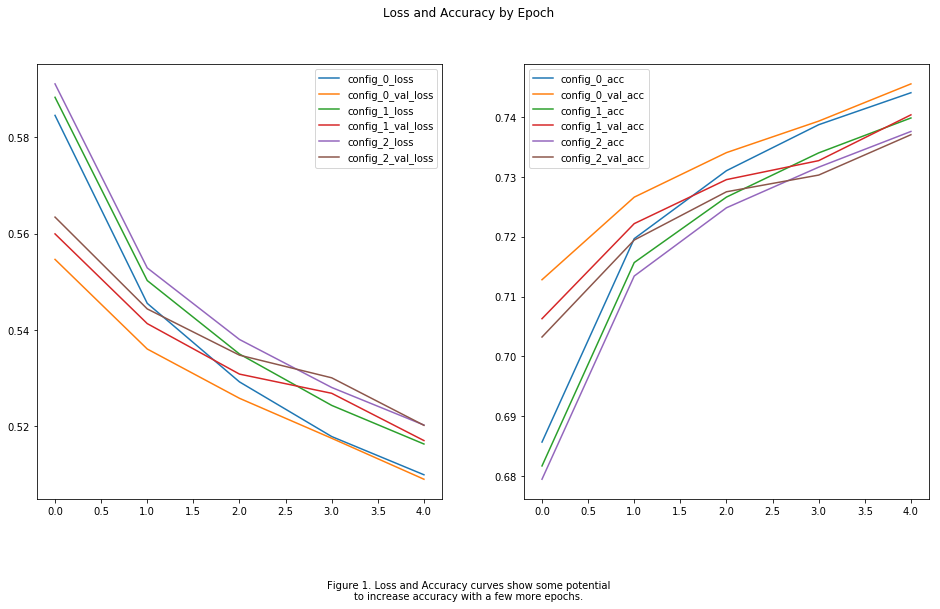

In [82]:
fig = plt.figure(figsize=(16,8))
plt.subplot(121)
for key in mods.keys():
    plt.plot(mods[key].train_history.epoch, mods[key].train_history.history['loss'],
             label='{}_loss'.format(key))
    if mods[key].train_history.history.get('val_loss', False) != False:
        plt.plot(mods[key].train_history.epoch, mods[key].train_history.history['val_loss'],
                 label='{}_val_loss'.format(key))
plt.legend()
plt.subplot(122)
for key in mods.keys():
    plt.plot(mods[key].train_history.epoch, mods[key].train_history.history['acc'],
             label='{}_acc'.format(key))
    if mods[key].train_history.history.get('val_acc', False) != False:
        plt.plot(mods[key].train_history.epoch, mods[key].train_history.history['val_acc'],
                 label='{}_val_acc'.format(key))
plt.legend()
plt.suptitle('Loss and Accuracy by Epoch')
fig.text(.5, -.05, 
         'Figure 1. Loss and Accuracy curves show some potential\nto increase accuracy with a few more epochs.',
         ha='center')
plt.show()

#### Extended Training
The plots above did not flatten by the end of the training and so more epochs are explored below.

In [90]:
layers = [[[300, "orthogonal", x] for x in [None, "relu", "relu", "relu"]],
          [[i, "orthogonal", x] for i, x in zip([20, 100,100,140], [None, "relu", "relu", "relu"])]
    ]

mods = {} #resetting our mods dictionary here
#this is the best optimizer settings as found in the previous exploration
opt = Adadelta(lr = 1.5, decay = 0.00001, rho=0.975, epsilon=3e-8)
es = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=0, mode='auto')
for i, mdl in enumerate(layers):
	print("-*"*40)
	print("LAYER CONFIG: {}".format(i))
	np.random.seed(128)
	mods.update({'config_{}'.format(i): modeler(layer, opt, x_test, y_test, x, y, callbacks=[es],
                                                mtrcs=['accuracy'], validation_split=0.1, epochs=100)})
	mods['config_{}'.format(i)].train_model()

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
LAYER CONFIG: 0
Train on 900000 samples, validate on 100000 samples
Epoch 1/100
 - 27s - loss: 0.5850 - acc: 0.6851 - val_loss: 0.5546 - val_acc: 0.7103
Epoch 2/100
 - 23s - loss: 0.5447 - acc: 0.7202 - val_loss: 0.5339 - val_acc: 0.7284
Epoch 3/100
 - 23s - loss: 0.5275 - acc: 0.7318 - val_loss: 0.5226 - val_acc: 0.7360
Epoch 4/100
 - 24s - loss: 0.5165 - acc: 0.7394 - val_loss: 0.5136 - val_acc: 0.7417
Epoch 5/100
 - 21s - loss: 0.5091 - acc: 0.7447 - val_loss: 0.5075 - val_acc: 0.7458
Epoch 6/100
 - 22s - loss: 0.5035 - acc: 0.7485 - val_loss: 0.5027 - val_acc: 0.7493
Epoch 7/100
 - 22s - loss: 0.4992 - acc: 0.7510 - val_loss: 0.5046 - val_acc: 0.7487
Epoch 8/100
 - 23s - loss: 0.4962 - acc: 0.7531 - val_loss: 0.4987 - val_acc: 0.7517
Epoch 9/100
 - 23s - loss: 0.4937 - acc: 0.7545 - val_loss: 0.4964 - val_acc: 0.7534
Epoch 10/100
 - 23s - loss: 0.4914 - acc: 0.7561 - val_loss: 0.4944 - val_acc: 0.7549


In [91]:
for key in mods.keys():
    print("="*30)
    print(key)
    print(mods[key].printScores())

config_0
           Test Loss: 0.4868
       Test accuracy: 0.7593
         Test ROCAUC: 0.8432
None
config_1
           Test Loss: 0.4905
       Test accuracy: 0.7567
         Test ROCAUC: 0.8401
None


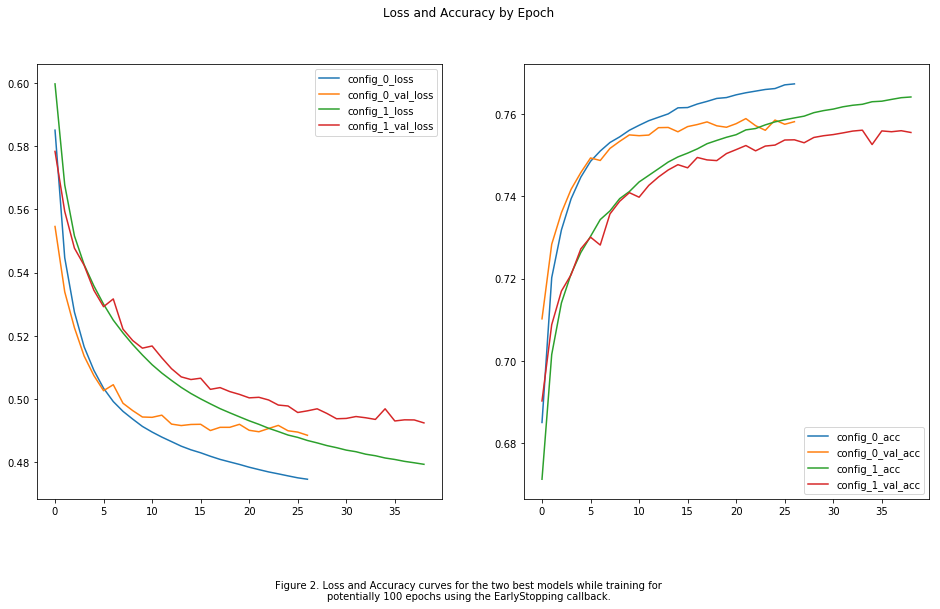

In [94]:
fig = plt.figure(figsize=(16,8))
plt.subplot(121)
for key in mods.keys():
    plt.plot(mods[key].train_history.epoch, mods[key].train_history.history['loss'],
             label='{}_loss'.format(key))
    if mods[key].train_history.history.get('val_loss', False) != False:
        plt.plot(mods[key].train_history.epoch, mods[key].train_history.history['val_loss'],
                 label='{}_val_loss'.format(key))
plt.legend()
plt.subplot(122)
for key in mods.keys():
    plt.plot(mods[key].train_history.epoch, mods[key].train_history.history['acc'],
             label='{}_acc'.format(key))
    if mods[key].train_history.history.get('val_acc', False) != False:
        plt.plot(mods[key].train_history.epoch, mods[key].train_history.history['val_acc'],
                 label='{}_val_acc'.format(key))
plt.legend()
plt.suptitle('Loss and Accuracy by Epoch')
fig.text(.5, -.05, 
         'Figure 2. Loss and Accuracy curves for the two best models while training for\npotentially 100 epochs using the EarlyStopping callback.',
         ha='center')
plt.show()

## Results
The best model achieved in this exploration had an AUROC of 0.8432 and an accuracy of 0.7593.

## Conclusion
Searching the parameter space of a neural network is an optimization problem that unfortunately can take a lot of time to perform. One potential downfall of the single parameter approach is the possibility that using only the best model from each step will provide limited (or no) knowledge of how the interaction of parameter values affects our AUROC value. One potential idea to combat this potential problem is to continually carry forward one or a few of the poor performing models into the next step of exploration. Another approach that is somewhat similar is to employ a genetic algorithm approach with varying mutation rates and population sizes however this is a bit more than could be feasibly explored in this assignment.

## References
[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

[2] Baldi, P, Sadowski, P, and Whiteson, D. "Searching for Exotic Particles in High Energy Physics with Deep Learning". Retrieved from https://www.nature.com/articles/ncomms5308. Retrieved on 2018/04/19 at 21:00 PST.